<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
</center>
<center>Автор материала: программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий

# <center>  Capstone проект №1. Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 3. Визуальный анализ данных и построение признаков

На 3 неделе мы займемся визуальным анализом данных и построением признаков. Сначала мы вместе построим и проанализируем несколько признаков, потом Вы сможете сами придумать и описать различные признаки. Задание имеет вид Peer-Review, так что творчество здесь активно приветствуется. Если задействуете IPython-виджеты, библиотеку Plotly, анимации и прочий интерактив, всем от этого будет только лучше.

**План 3 недели:**
 - Часть 1. Построение признаков
 - Часть 2. Визуальный анализ данных
 - Часть 3. Дальнейшее построение признаков
 - Часть 4. Проверка построенных признаков

**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Поиск структуры в данных":**
   - [Задача визуализации](https://www.coursera.org/learn/unsupervised-learning/lecture/hlvlT/zadacha-vizualizatsii)
   - [Визуализация данных в sklearn](https://www.coursera.org/learn/unsupervised-learning/lecture/ityMo/vizualizatsiia-dannykh-v-sklearn)
   
**Также в задании будет использоваться библиотека Seaborn (ее можно дополнительно установить командой *pip install seaborn*), будет полезно обращаться к документациям [Matplotlib](http://matplotlib.org/users/) и [Seaborn](http://seaborn.pydata.org/), а также к примерам визуализации, описанным на StackOverflow.**



## Часть 1. Построение признаков

In [2]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import os
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
pd.set_option('display.max.columns', 25)
import pickle
#pip install seaborn
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
import datetime
import re

In [3]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = ('./')

**Создайте на основе функций *prepare_train_set* и *prepare_sparse_train_set_window*  новую – *prepare_train_set_with_fe*, (от "feature engineering"), создайте следующие признаки:**
- `session_timespan` – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах)
- `#unique_sites` – число уникальных сайтов в сессии 
- `start_hour` – час начала сессии (то есть час в записи минимального timestamp среди десяти)
- `day_of_week` – день недели (то есть день недели в записи минимального timestamp среди десяти)

Функция должна возвращать новый DataFrame (как возвращала функция *prepare_train_set*), только признаков должно быть на 4 больше. Порядок, в котором добавляются признаки: *site1*, ... *site10*, *session_timespan*, *#unique_sites*, *start_hour*, *day_of_week* и *user_id* (это видно и чуть ниже по тому, как функция вызывается).

In [4]:
def sm(X):
    row=[]
    for i in range(0,X.shape[0]):
        row.extend(i*np.ones(X.shape[1], dtype="int"))
    return dropcols_coo(csr_matrix((np.ones(X.size, dtype="int"), 
                                (row, 
                                 X.reshape(X.size, 1).squeeze())
                               )), 0)

def dropcols_coo(M, idx_to_drop):
    idx_to_drop = np.unique(idx_to_drop)
    C = M.tocoo()
    keep = ~np.in1d(C.col, idx_to_drop)
    C.data, C.row, C.col = C.data[keep], C.row[keep], C.col[keep]
    C.col -= idx_to_drop.searchsorted(C.col)    # decrement column indices
    C._shape = (C.shape[0], C.shape[1] - len(idx_to_drop))
    return C.tocsr()

In [5]:
def prepare_train_set_with_fe(path_to_csv_files, site_freq_path, feature_names,
                                    session_length=10, window_size=10):

    f=glob(os.path.join(PATH_TO_DATA, path_to_csv_files, "*.csv"))
    
    df = pd.DataFrame(columns=['timestamp', 'site', "user_id"])
    for i in f:
        td = pd.read_csv(i, parse_dates=[0])
        td["user_id"] = int(re.search("(\d){4}",i).group())
        df = pd.concat([df, td], axis=0)
    #print(df)
    with open(os.path.join(PATH_TO_DATA, site_freq_path), 'rb') as dic_pkl:
        sites = pickle.load(dic_pkl)
    #print(sites)
    du = df.groupby("user_id")
    s = []
    for name, group in du:
        #print(name, group)
        for j in range(0, int(np.ceil(group.shape[0] / window_size))):
            site = []
            last_visit=0
            for i in range(0, session_length):
                try:
                    site.append(sites[group["site"][j*window_size+i]][0]) 
                    last_visit=group["timestamp"][j*window_size+i]
                except:
                    site.append(0)
            #продолжительность сессии
            duration=pd.Timedelta(last_visit - group["timestamp"][j*window_size]).total_seconds()
            #print(duration)
            site.append(duration)
            #кол-во уникальных
            n_uniq=np.unique(site[:-1])
            #print(n_uniq, site)
            if n_uniq[0] < 1:
                n_uniq=n_uniq[1:]
            site.append(len(n_uniq))
            #start_hour
            site.append(pd.Timestamp(group["timestamp"][j*window_size]).hour)
            #day of week
            site.append(pd.Timestamp(group["timestamp"][j*window_size]).dayofweek)
            site.append(name)
            #print(site)
            s.append(site)
    #print(s)

    cn = [str(i) for i in range(1,session_length+1)]
    cn.extend(feature_names)
    cn.append("user_id")
    ss = pd.DataFrame(data=s, columns=cn)        
    #return dropcols_coo(sm(ss.to_numpy()), 0)
    return ss

**Проверим функцию на игрушечном примере.**

In [6]:
feature_names =['session_timespan', '#unique_sites', 'start_hour', 'day_of_week']
train_data_toy  = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '3users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_3users.pkl'),
                  feature_names=feature_names, session_length=10)

FileNotFoundError: [Errno 2] No such file or directory: '././site_freq_3users.pkl'

In [7]:
train_data_toy

NameError: name 'train_data_toy' is not defined

**Примените функцию *prepare_train_set_with_fe* к данным по 10 пользователям, укажите *session_length*=10.**

In [226]:
train_data_10users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '10users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_10users.pkl'),
                  feature_names=feature_names, session_length=10)

In [229]:
train_data_10users.head()

,1,2,3,4,5,6,7,8,9,10,session_timespan,#unique_sites,start_hour,day_of_week,user_id
0,173,1161,1162,17,1162,1162,17,1162,48,1162,33.0,5,8,4,31
1,332,147,196,99,1162,20,1163,1164,352,1165,284.0,10,8,4,31
2,1165,17,1165,1165,28,197,332,29,1166,1165,258.0,7,8,4,31
3,356,1167,356,1165,1165,1165,1165,141,347,346,30.0,6,8,4,31
4,193,1165,28,1168,232,185,1169,1170,451,1170,6.0,9,8,4,31


**Примените функцию *prepare_train_set_with_fe* к данным по 150 пользователям, укажите *session_length*=10.**

In [232]:
train_data_150users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '150users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_150users.pkl'),
                  feature_names=feature_names, session_length=10)

**Сохраните в pickle-файлы признаки *session_timespan*, *#unique_sites*, *start_hour* и *day_of_week* для 10 и 150 пользователей.**

In [233]:
new_features_10users = train_data_10users[feature_names]
new_features_150users = train_data_150users[feature_names]

In [234]:
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_10users.pkl'), 'wb') as new_features_10users_pkl:
    pickle.dump(new_features_10users, new_features_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_150users.pkl'), 'wb') as new_features_150users_pkl:
    pickle.dump(new_features_150users, new_features_150users_pkl)

## Часть 2. Визуальный анализ данных

**Забавы ради, для потехи дадим пользователям имена и ассоциируем с ними цвета.**

In [173]:
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
train_data_10users['target'] = train_data_10users['user_id'].map(id_name_dict)

In [174]:
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

**1. Постройте гистограмму распределения длины сессии в секундах (*session_timespan*). Ограничьте по *x* значением 200 (иначе слишком тяжелый хвост). Сделайте гистограмму цвета *darkviolet*, подпишите оси по-русски.**

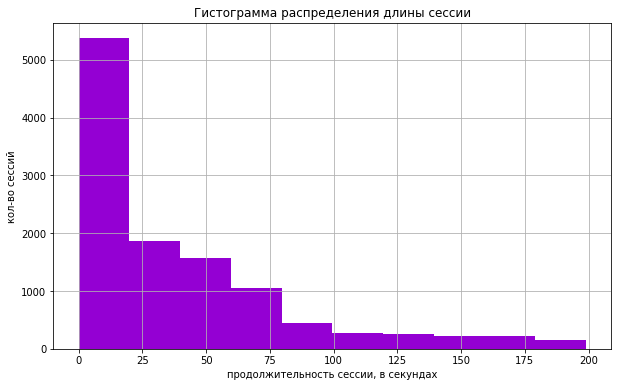

In [132]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.title("Гистограмма распределения длины сессии") 
plt.xlabel("продолжительность сессии, в секундах") # ось абсцисс
plt.ylabel("кол-во сессий") # ось ординат
train_data_10users['session_timespan'][train_data_10users['session_timespan'] < 200].hist(color="darkviolet")


**2. Постройте гистограмму распределения числа уникальных сайтов в сессии (*#unique_sites*). Сделайте гистограмму цвета *aqua*, подпишите оси по-русски.**

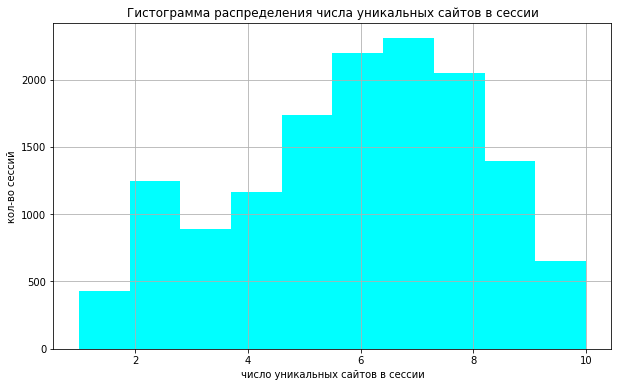

In [133]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.title("Гистограмма распределения числа уникальных сайтов в сессии") 
plt.xlabel("число уникальных сайтов в сессии") # ось абсцисс
plt.ylabel("кол-во сессий") # ось ординат

train_data_10users['#unique_sites'].hist(color="aqua")

**3. Постройте гистограммы распределения числа уникальных сайтов в сессии (*#unique_sites*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

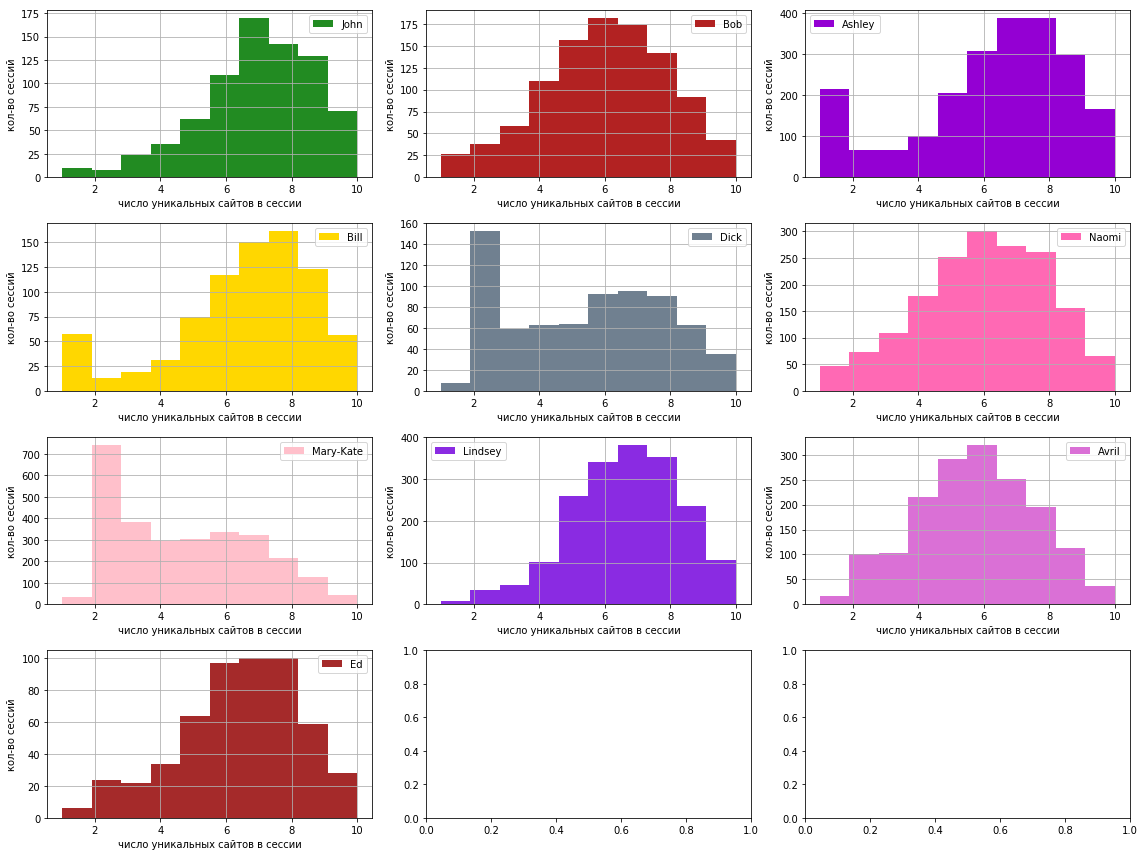

In [206]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(16, 12))


# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(train_data_10users.groupby('user_id')): 
    plt.subplot(4,3,idx+1)
    plt.xlabel("число уникальных сайтов в сессии") # ось абсцисс
    plt.ylabel("кол-во сессий") # ось ординат
    sub_df['#unique_sites'].hist(color=color_dic[id_name_dict[user]], label=id_name_dict[user])
    plt.legend()
    plt.tight_layout() 

**4. Постройте гистограмму распределения часа начала сессии (*start_hour*). Сделайте гистограмму цвета *darkgreen*, подпишите оси по-русски.**

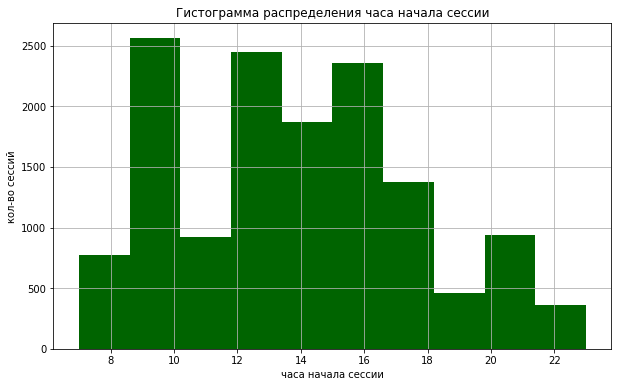

In [218]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.title("Гистограмма распределения часа начала сессии") 
plt.xlabel("часа начала сессии") # ось абсцисс
plt.ylabel("кол-во сессий") # ось ординат
train_data_10users['start_hour'].hist(color="darkgreen")

**5. Постройте гистограммы распределения часа начала сессии (*start_hour*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

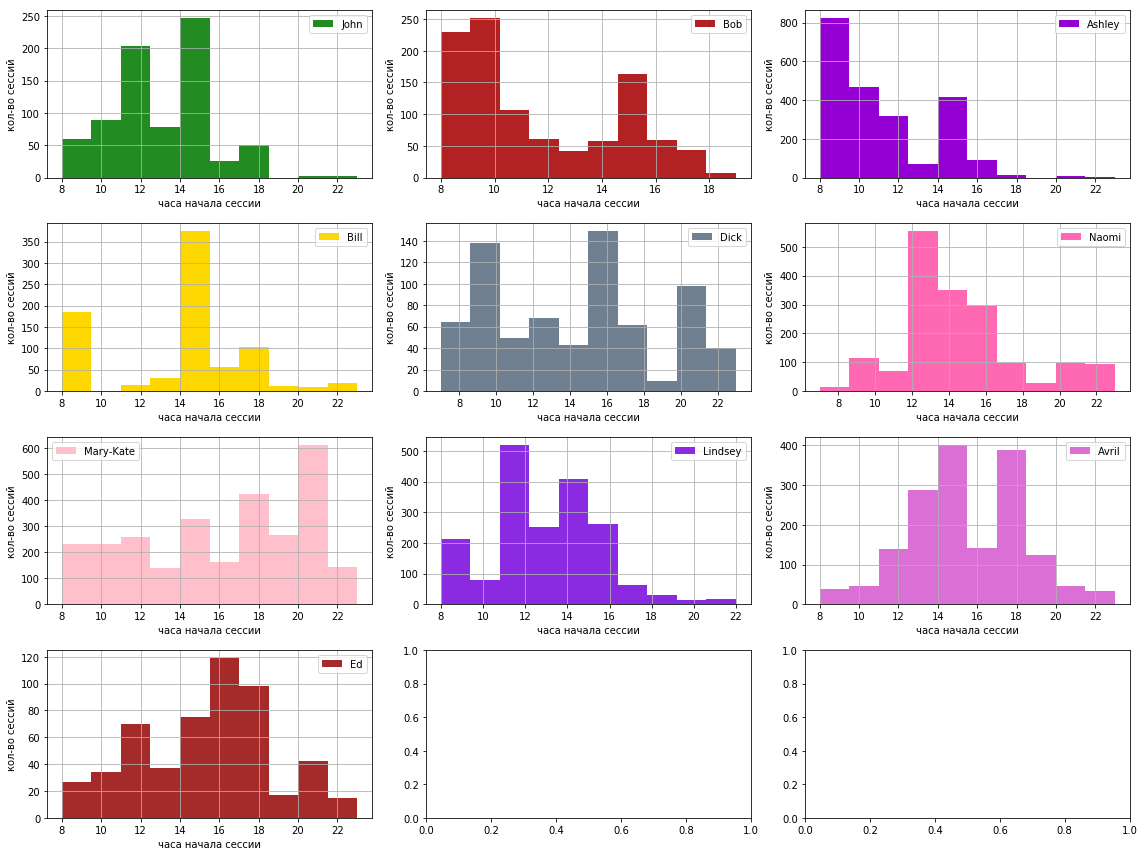

In [216]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(16, 12))


# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(train_data_10users.groupby('user_id')): 
    plt.subplot(4,3,idx+1)
    plt.xlabel("часа начала сессии") # ось абсцисс
    plt.ylabel("кол-во сессий") # ось ординат
    sub_df['start_hour'].hist(color=color_dic[id_name_dict[user]], label=id_name_dict[user])
    plt.legend()
    plt.tight_layout()



**6. Постройте гистограмму распределения дня недели, в который началась сессия (*day_of_week*). Сделайте гистограмму цвета *sienna*, подпишите оси по-русски.**

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.title("Гистограмма распределения дня недели, в который началась сессия ") 
plt.xlabel("день недели начала сессии") # ось абсцисс
plt.ylabel("кол-во сессий") # ось ординат
train_data_10users['day_of_week'].hist(color="sienna", bins=[0, 1, 2, 3, 4, 5, 6, 7])

**7. Постройте гистограммы распределения дня недели, в который началась сессия (*day_of_week*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Измените метки по оси *X* на ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'] – метод *set_xticklabels*. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите по-русски название каждой из 10 гистограмм.**

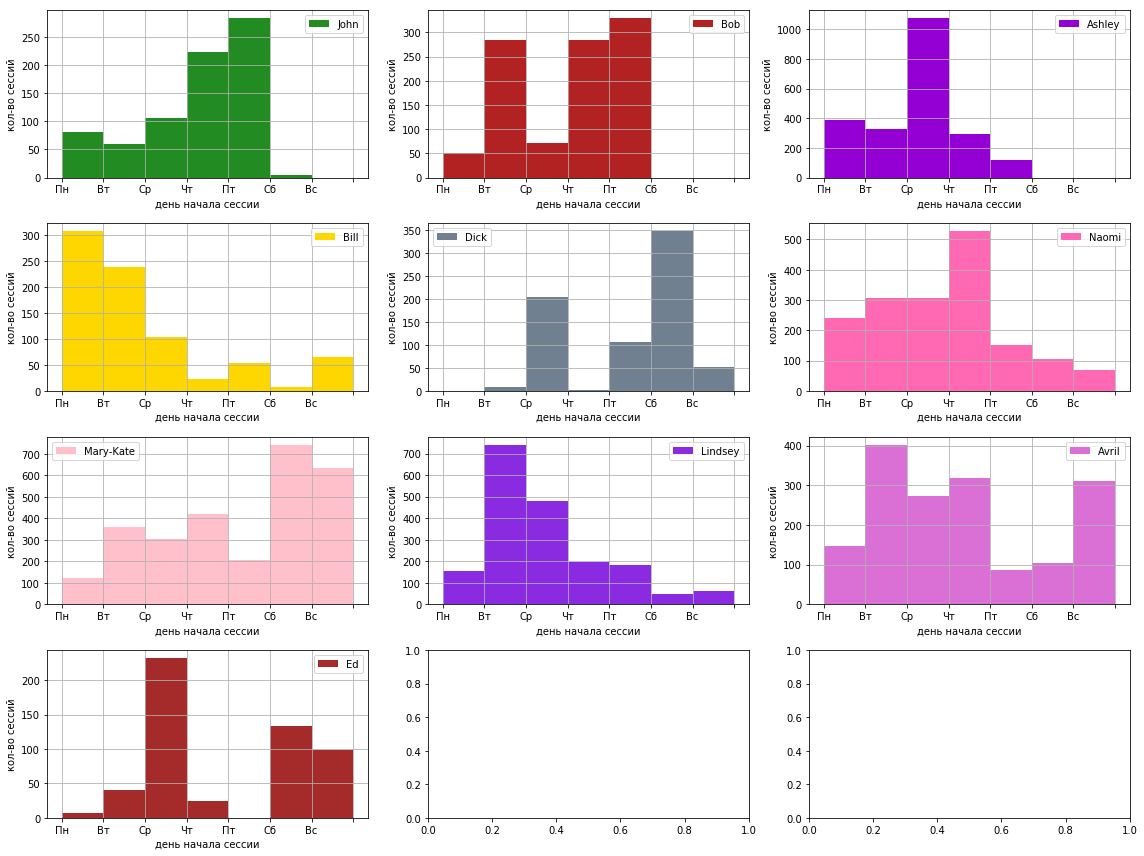

In [607]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(16, 12))

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(train_data_10users.groupby('user_id')): 
    #print(id_name_dict[user], np.histogram(sub_df['day_of_week'].to_numpy(), bins=[0, 1, 2, 3, 4, 5, 6, 7]))
    ax = plt.subplot(4,3,idx+1)
    plt.xlabel("день начала сессии") # ось абсцисс
    plt.ylabel("кол-во сессий") # ось ординат
    ax.set_xticklabels(['','Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс',''])
    sub_df['day_of_week'].hist(bins=[0, 1, 2, 3, 4, 5, 6, 7], color=color_dic[id_name_dict[user]], label=id_name_dict[user])
    plt.legend()
    plt.tight_layout()

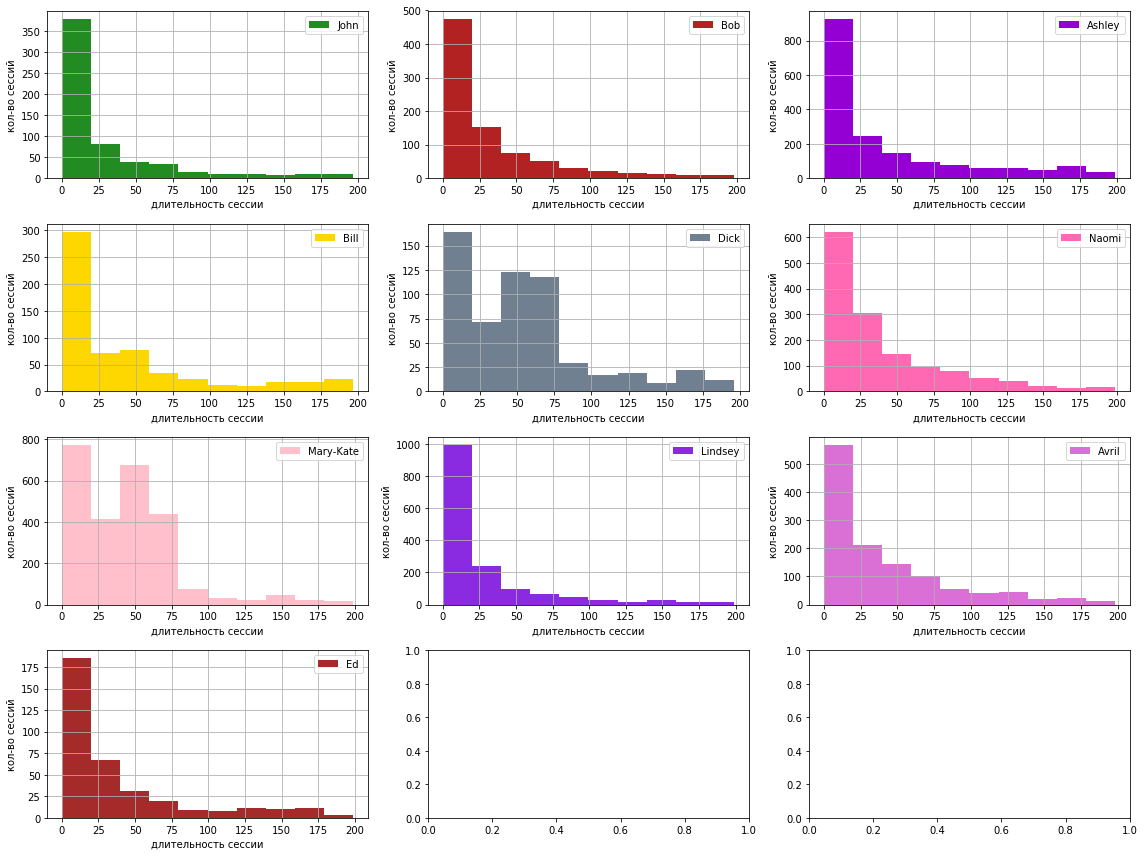

In [267]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(16, 12))

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(train_data_10users.groupby('user_id')): 
    ax = plt.subplot(4,3,idx+1)
    plt.xlabel("длительность сессии") # ось абсцисс
    plt.ylabel("кол-во сессий") # ось ординат
    sub_df['session_timespan'][sub_df['session_timespan'] < 200].hist(color=color_dic[id_name_dict[user]], label=id_name_dict[user])
    plt.legend()
    plt.tight_layout()

**8. Сделайте выводы про каждого пользователя по построенным графикам.**

# Dick
Сидит в интернете всю пятницу и часть вторника. Самые длинные сессии. Видимо, смотрит видео. М.б. мусульманин. Чаще всего в сессии 2 сайта и больше. Mary-Kate и  Dick очень похожи по всем распределениям

# Ed
Сидит в интернете в среду и выходные. Больше в середине дня. Есть дилнные сессии. Сессии разнообразные

# Bob
Сидит в интернете во вторник и в выходные. По утрам и в 15 часов. Сессии короткие. Разнообразие распределено нормально

# Bill
Длинный и тяжелый хвост по длительности сессий. Много пользуется интернетом в пн, вт. Утром и в течение дня с пиком в обед. Часто в сессии 1 сайт. Остальное разнообразие распределно нормально с пиков в 8. 

# Jonh
Сидит в интернете в рабочие дни в рабочее время. В остальное время практически не пользуется. Сессии короткие и более разнообразные, чем среднее. Работает человек.

# Mary-Kate
Сидит в интернете по выходным. В будни пользуется интернетом не часто. Сессия часто начинается в обед и вечером. В основном заходит на 2 сайта. Иногда посещает больше 2 сайтов. Сессии длинные (до 80 сек) Скорее всего смотрит видео. Mary-Kate и  Dick очень похожи по всем распределениям

# Ashley
Сидит в интернете в рабочие дни, чаще всего в среду. Уникальных сайтов в сессии 1 или 6-8

# Lindsey
Сидит в интернете во вторник, среду днем. Сайтов в сессии 6-8. Сессии короткие. Возможно, выполняет рабочее задание

# Naomi
Сидит в интернете в рабочие дни в рабочее время. Сессии разной продолжительности. Вероятно, работает. Разнообразие побольше, чем в среднем.

# Avril
Пользуется интернетом каждый день. Два всплеска в день: в 14 и в 18 часов. Сессии короткие. Разнообразие нормальное

**Загрузите сохраненный ранее в pickle-файл частотный словарь сайтов для 10 пользователей. **

In [241]:
with open(os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'), 'rb') as dic_pkl:
    sites = pickle.load(dic_pkl)

**Определите топ-10 самых посещаемых сайтов (*top10_sites*) и соответствующие кол-ва посещений (*top10_freqs*).**

In [250]:
top10_popular = sorted(sites.items(), key=lambda kv: kv[1][1], reverse=True)[:10]
top10_freqs = [i[1][1] for i in top10_popular]
print(top10_freqs)
top10_sites = [i[0] for i in top10_popular]


[8300, 7813, 5441, 4158, 4141, 3758, 3244, 3094, 2630, 2089]


**9. Нарисуйте *seaborn barplot*, показывающий частоты посещений топ-10 сайтов. Сделайте подписи сайтов вертикальными, иначе они сливаются (*xticks*).**

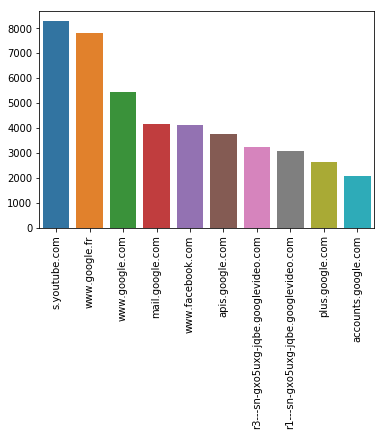

In [261]:
ax = sns.barplot(x=top10_sites, y=top10_freqs)
ax.set_xticklabels(top10_sites, rotation=90)
pass

## Часть 3. Проверка построенных признаков
Эта часть скорее техническая, смысл ее – убедиться, что мы все одинаково создали признаки *session_timespan, #unique_sites, start_hour* и *day_of_week*.

**10. Выведите медианную продолжительность сессии (*session_timespan*) для сессий 10 пользователей.**

In [271]:
train_data_10users['session_timespan'].median()

37.0

**11. Выведите медианный день недели, в который началась сессия, для сессий 10 пользователей.**

In [236]:
train_data_10users['day_of_week'].median()

2.0

**12. Выведите медианный час начала сессии для сессий 150 пользователей.**

In [239]:
train_data_150users['start_hour'].median()

13.0

**13. Выведите медианное значение числа уникальных сайтов в сессиях 150 пользователей.**

In [240]:
train_data_150users['#unique_sites'].median()

7.0

## Часть 4. Дальнейшее построение признаков

Это задание творческое, тут надо придумать, как еще учесть время посещения веб-страниц и прочие признаки. 

На следующей неделе мы будем использовать "мешок" сайтов  для классификации сессий по принадлежности разным пользователям, а эти новые признаки, которые Вы сейчас создадите, потом добавим и посмотрим, улучшается ли модель. Поэтому можно их создать в виде отдельных матриц и сохранить их также отдельно.  

В этой части задания Вы можете построить и визуально исследовать самые разные признаки (ничто фантазию не ограничивает):
- год, месяц и день начала сессии
- час начала сессии (с учетом года, месяца и дня)
- время суток
- среднее время пребывания на сайте, посчитать можно, скажем, для топ-30 популярных сайтов
- индикаторы посещения популярных сайтов (скажем, тоже для топ-30 популярных сайтов)
- частота посещения Facebook
- ...

**Напишите функцию для создания новых признаков и примените ее к исходным данным – каталогам с 10 и 150 файлами. Сделайте это только для набора данных, полученного с параметрами *session_length=10* и *window_size=10*. Сериализуйте полученные матрицы с помощью pickle. Функция может возвращать как только новые признаки, так и старые с новыми. При этом сигнатура функции может быть другой – тут уже свобода выбора.**

## Время, которое человек провел в каждой категории сайтов. 
Категории сочинены на основе top50 сайтов по посещаемости. 
Продолжительность визита ограничена 200 сек.
Отдельный dataframe для этого признака.

In [ ]:
#top50=top10_popular = sorted(sites.items(), key=lambda kv: kv[1][1], reverse=True)[:70]
#top50

In [494]:
category={1: "video", 2: "personal", 3: "search", 4: "social", 5: "data collector", 6: 
          "other", 7: "study", 8: "api", 9:"safety", 10:"youtube history", 11: "mail", 
          12: "docs+ofiice", 13: "programming"}

In [618]:
topsites = {'s.youtube.com':10,'www.google.fr': 3,'www.google.com': 3, 'google.fr': 3, 'google.com': 3,
            'mail.google.com':11, 'www.facebook.com': 4,'apis.google.com': 8,
            'r3---sn-gxo5uxg-jqbe.googlevideo.com': 1, 'i1.ytimg.com':1, 'fr.openclassrooms.com':8,
            'r1---sn-gxo5uxg-jqbe.googlevideo.com':1,'plus.google.com':11,'accounts.google.com':2,
            'r2---sn-gxo5uxg-jqbe.googlevideo.com':1,'fr-mg42.mail.yahoo.com':11,'www.youtube.com':1,
            'r4---sn-gxo5uxg-jqbe.googlevideo.com':1,'clients1.google.com':5,'download.jboss.org': 7,
            's-static.ak.facebook.com':5,'static.ak.facebook.com':5,'i1.ytimg.com':6,'twitter.com':4,
            'accounts.youtube.com':1,'platform.twitter.com':8,'safebrowsing-cache.google.com':9,
            'clients6.google.com':5,'translate.google.fr':3, 'translate.google.com': 3, 'api.twitter.com':8,'accounts.google.fr':2,
            'talkgadget.google.com':4, 'safebrowsing.clients.google.com': 9, 'login.live.com': 12,
            'office.microsoft.com': 12, 'webmail.laposte.net' : 11, 'drive.google.com':12, 'maps.googleapis.com':8}

In [619]:
#Время по категориям time_by_category
def prepare_train_set_newf(path_to_csv_files, site_freq_path, session_length=10, window_size=10):

    f=glob(os.path.join(PATH_TO_DATA, path_to_csv_files, "*.csv"))
    
    df = pd.DataFrame(columns=['timestamp', 'site', "user_id"])
    for i in f:
        td = pd.read_csv(i, parse_dates=[0])
        td["user_id"] = int(re.search("(\d){4}",i).group())
        df = pd.concat([df, td], axis=0)
    print(df.info())
    with open(os.path.join(PATH_TO_DATA, site_freq_path), 'rb') as dic_pkl:
        sites = pickle.load(dic_pkl)
    #print(sites)
    du = df.groupby("user_id")
    columns=[i for i in category.values()] + ["user_id"]
    s = pd.DataFrame(columns = columns)
    for name, group in du:
        #print(name, group)
        for j in range(0, int(np.ceil(group.shape[0] / window_size))):
            data={i:0 for i in category.values()}
            for i in range(0, session_length):
                try:
                    c = category[topsites[group["site"][j*window_size+i]]]
                    t = pd.Timedelta(group["timestamp"][j*window_size+ 1 + i] - 
                                     group["timestamp"][j*window_size + i]).total_seconds()
          
                    if t> 200:
                        t=200
                    #print("data", c, t, data[c])
                    data.update({c: data[c] + t})
                except:
                    pass
            site = pd.DataFrame(data = data, index=[0], columns = columns)
            site["user_id"].loc[0] = name
            #print(site)
            s = pd.concat([s, site], ignore_index=True)
    #print(s)

    return s

train_data_10users_newf = prepare_train_set_newf(os.path.join(PATH_TO_DATA, 
                                                         '10users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_10users.pkl'), session_length=10)



<class 'pandas.core.frame.DataFrame'>
Int64Index: 140574 entries, 0 to 7197
Data columns (total 3 columns):
timestamp    140574 non-null datetime64[ns]
site         140574 non-null object
user_id      140574 non-null object
dtypes: datetime64[ns](1), object(2)
memory usage: 4.3+ MB
None


In [ ]:
train_data_150users_newf = prepare_train_set_newf(os.path.join(PATH_TO_DATA, 
                                                         '150users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_150users.pkl'), session_length=10)

In [ ]:
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_cat_10users.pkl'), 'wb') as new_features_10users_pkl:
    pickle.dump(train_data_10users_newf, new_features_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_cat_150users.pkl'), 'wb') as new_features_150users_pkl:
    pickle.dump(train_data_150users_newf, new_features_150users_pkl)

## Время суток и рабочее/нерабочее время
Отдельный датафрейм

In [ ]:

columns=["morning", "day", "evening", "night", "workhours", "resttime", "user_id"]
def prepare_train_set_newf(path_to_csv_files, site_freq_path, session_length=10, window_size=10):

    f=glob(os.path.join(PATH_TO_DATA, path_to_csv_files, "*.csv"))
    
    df = pd.DataFrame(columns=['timestamp', 'site', "user_id"])
    for i in f:
        td = pd.read_csv(i, parse_dates=[0])
        td["user_id"] = int(re.search("(\d){4}",i).group())
        df = pd.concat([df, td], axis=0)
    #print(df.info())
    with open(os.path.join(PATH_TO_DATA, site_freq_path), 'rb') as dic_pkl:
        sites = pickle.load(dic_pkl)
    #print(sites)
    du = df.groupby("user_id")
    site = []
    for name, group in du:
        #print(name, group)
        for j in range(0, int(np.ceil(group.shape[0] / window_size))):
            data=pd.DataFrame(columns = columns)
            data = pd.concat([data, pd.Series(data=[0 for i in range(0, session_length)])])
            for i in range(0, session_length):
                try:
                    #переписать это место на средние за сессии 
                    #А то сейчас у меня получаются данные за конец сессии
                    #и в предыдущей фичи, скорее всего, такая же ошибка
                    
                    h=group["timestamp"][j*window_size + i].hour
                    d=group["timestamp"][j*window_size + i].dayofweek
                    #print(h,d)
                    data["workhours"].iloc[i] = 1
                    if d >4:
                        data["workhours"].iloc[i] = 0
                    elif h<8 or h>16:
                        data["workhours"].iloc[i] = 0
                    if data["workhours"].iloc[i] == 0:
                        data["resttime"].iloc[i] = 1
                    else:
                        data["resttime"].iloc[i] = 0
                    if h>5 and h<9:
                        data["morning"].iloc[i] = 1
                    elif h>8 and h<17:
                        data["day"].iloc[i] = 1
                    elif h>16 and h<23:
                        data["evening"].iloc[i] = 1
                    else:
                        data["night"].iloc[i] = 1
                    data["user_id"] = name
                except:
                    pass
            data=data.drop(columns=[0]).fillna(0)
            dd = list(data.mean(axis=0).to_numpy())
            site.append(dd)
            #print(len(site))
    s = pd.DataFrame(data = site, columns = data.columns)
    #print(s)

    return s

train_data_10users_newf2 = prepare_train_set_newf(os.path.join(PATH_TO_DATA, '10users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_10users.pkl'), session_length=10)


In [ ]:
train_data_150users_newf2 = prepare_train_set_newf(os.path.join(PATH_TO_DATA, 
                                                         '150users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_150users.pkl'), session_length=10)

In [ ]:
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_timecat_10users.pkl'), 'wb') as new_features_10users_pkl:
    pickle.dump(train_data_10users_newf2, new_features_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_timecat_150users.pkl'), 'wb') as new_features_150users_pkl:
    pickle.dump(train_data_150users_newf2, new_features_150users_pkl)

## Время, которое человек провел в каждой категории сайтов. 
Категории сочинены на основе top50 сайтов по посещаемости. 
Продолжительность визита ограничена 200 сек.
Отдельный dataframe для этого признака.

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(16, 20))
for idx, (user, sub_df) in  enumerate(train_data_10users_newf.groupby('user_id')):   
    ax = plt.subplot(4,3,idx+1)
    ax.bar(x = train_data_10users_newf.columns[:-1], 
                 height =train_data_10users_newf[train_data_10users_newf["user_id"] == user].iloc[:,:-1].sum(),
                 label=id_name_dict[user], color=color_dic[id_name_dict[user]])
    ax.set_xlabel("категории") # ось абсцисс
    ax.set_ylabel("продолжительность") # ось ординат
    ax.set_xticklabels(category.values(), rotation=90)
    ax.legend()
    fig.tight_layout()
plt.show()

## Распределение времени выхода в интернет вцелом

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(16, 20))
for idx, (user, sub_df) in  enumerate(train_data_10users_newf2.groupby('user_id')): 
    sub_df = sub_df.drop(columns=["user_id"])
    ax = plt.subplot(4,3,idx+1)
    ax.bar(x = sub_df.columns, height =sub_df.mean(),
                 label=id_name_dict[user], color=color_dic[id_name_dict[user]])
    ax.set_xlabel("категории") # ось абсцисс
    ax.set_ylabel("кол-во") # ось ординат
    ax.set_xticklabels(sub_df.columns, rotation=90)
    ax.legend()
    fig.tight_layout()
plt.show()

## Распределение времени суток вне рабочего времени
если доля дневных часов высокая - человек сидел в интернете в выходной

**14. Постройте картинки для новых признаков, поисследуйте их, прокомментируйте результаты.**

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(16, 20))
for idx, (user, sub_df) in  enumerate(train_data_10users_newf2.groupby('user_id')): 
    sub_df = sub_df.where(sub_df["resttime"]>0.5).drop(columns=["user_id"])
    ax = plt.subplot(4,3,idx+1)
    ax.bar(x = sub_df.columns, height =sub_df.mean(),
                 label=id_name_dict[user], color=color_dic[id_name_dict[user]])
    ax.set_xlabel("категории") # ось абсцисс
    ax.set_ylabel("кол-во") # ось ординат
    ax.set_xticklabels(sub_df.columns, rotation=90)
    ax.legend()
    fig.tight_layout()
plt.show()

# Дополненные описания персонажей

# Dick
Сидит в интернете преимущественно в выходные днем и реже вечером. Самые длинные сессии. Видимо, смотрит видео. Чаще всего в сессии 2 сайта и больше. Работает с почтой, что-то ищет в поисковиках. Чуть реже смотрит видео. Пользуется приложениями с Google Safe Browsing Mary-Kate и  Dick очень похожи по всем распределениям

# Ed
Сидит в интернете в среду и выходные. Больше в середине дня и вечером. Есть длинные сессии. Сессии разнообразные. Почта, поиск. Пользуется приложениями с Google Safe Browsing


# Bob
Сидит в интернете в рабочие дни. Днем (в начале и в 15 часов). Сессии короткие, в основном - поисковики. Разнообразие распределено нормально

# Bill
Длинный и тяжелый хвост по длительности сессий. Много пользуется интернетом в пн, вт. Утром и в течение дня с пиком в обед. Часто в сессии 1 сайт. Остальное разнообразие распределно нормально с пиков в 8. Сидит в интернете в основном днем, в т.ч. в воскресенье. Иногда вечером. В основном почта и поиск. Нет истории просмотров на youtube. В основном пользуется приложениями с Google Safe Browsing

# Jonh
Сидит в интернете в рабочие дни в рабочее время. Работает с почтой и с документами. Иногда ищет. В остальное время практически не пользуется. Сессии короткие и более разнообразные, чем среднее. Работает человек. Пользуется приложениями с Google Safe Browsing

# Mary-Kate
Сидит в интернете по выходным. В будни пользуется интернетом не часто. Сессия часто начинается в обед и вечером. В основном заходит на 2 сайта. Иногда посещает больше 2 сайтов. Сессии длинные (до 80 сек) Смотрит много видео. Тае же заходит в почту и в социальные сети.   Mary-Kate и  Dick очень похожи по всем распределениям. Только она не пользуется приложениями с Google Safe Browsing

# Ashley
Сидит в интернете в рабочие дни, чаще всего в среду. Утром и днем. Уникальных сайтов в сессии 1 или 6-8 (больше среднего). В его сессиях много служебных урлов. Пользуется почти всеми категориями сайтов, кроме видео. Нет истории промотров на youtube. Много заходов через  приложения с Google Safe Browsing


# Lindsey
Сидит в интернете во вторник, среду днем. Вне рабочего времени пользуется интернетом мало.  Сайтов в сессии 6-8. Сессии короткие. Почта, поиск, api. Мало видео, сочиальных сетей. Возможно, выполняет рабочее задание

# Naomi
Сидит в интернете в рабочие дни в рабочее время. Иногда по вечерам. В пт и в выходные мало. В  Сессии разной продолжительности. Почта, поиск, социальные сети. Вероятно, работает. Разнообразие побольше, чем в среднем.

# Avril
Пользуется интернетом каждый день. Два всплеска в день: в 14 и в 18 часов. Сессии короткие. Разнообразие нормальное. Почта, поиск, социальные сети. 

**В конце сохраните в pickle-файлы только те признаки, которые, как Вы предполагаете, помогут идентифицировать пользователя более точно. Это касается и признаков, которые мы вместе создали в начале (*session_timespan, #unique_sites, start_hour, day_of_week*), и Ваших собственных. Можно создать все эти признаки не только для сессий из 10 сайтов, но и для других сочетаний параметров *session_length* и *window_size*.**

In [ ]:
selected_features_10users = ''' ВАШ КОД ЗДЕСЬ ''' 
selected_features_150users = ''' ВАШ КОД ЗДЕСЬ ''' 

In [ ]:
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_10users.pkl'), 'wb') as selected_features_10users_pkl:
    pickle.dump(selected_features_10users, selected_features_10users_pkl, 
                protocol=2)
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_150users.pkl'), 'wb') as selected_features_150users_pkl:
    pickle.dump(selected_features_150users, selected_features_150users_pkl, 
                protocol=2)

## Критерии оценки работы:
- Верно ли отображена гистограмма session_timespan из п. 1? (max. 3 балла)
- Верно ли отображена гистограмма #unique_sites из п. 2? (max. 3 балла)
- Верно ли отображены гистограммы #unique_sites по каждому пользователю из п. 3? (max. 6 баллов)
- Верно ли отображена гистограмма start_hour из п. 4? (max. 3 балла)
- Верно ли отображены гистограммы start_hour по каждому пользователю из п. 5? (max. 6 баллов)
- Верно ли отображена гистограмма day_of_week из п. 6? (max. 3 балла)
- Верно ли отображены гистограммы day_of_week по каждому пользователю из п. 7? (max. 6 баллов)
- Насколько сделанные выводы в п. 8 соответствуют построенным картинкам? (max. 6 баллов)
- Верно ли отображен barplot для 10 популярных сайтов из п. 9? (max. 6 баллов)
- Правильно ли посчитана медианная продолжительность сессий в п. 10? (max. 3 балла)
- Правильно ли посчитан медианный день недели начала сессии в п. 11? (max. 3 балла)
- Правильно ли посчитан медианный час начала сессии в п. 12? (max. 3 балла)
- Правильно ли посчитано медианное значение числа уникальных сайтов в сессиях 150 пользователей п. 13? (max. 3 балла)
- Есть ли оригинальные построенные признаки и картинки к ним? Оцените также и качество картинок. (max. 8 баллов)

## Пути улучшения
7 неделя посвящена общему описанию проекта (`html`, `ipynb` или `pdf`) и взаимному оцениванию. Что еще можно добавить по 3 части проекта:
- IPython-widgets, интерактив и анимация (стоящие статьи по этому ремеслу – [раз](https://habrahabr.ru/post/308162/) и  [два](https://habrahabr.ru/company/ods/blog/323210/))
- можно попробовать изобразить исходные данные в некотором пространстве, например, Word2Vec, потом выделить главные компоненты или t-SNE  (только пользуйтесь эффективными реализациями типа [Multicore-TSNE](https://github.com/DmitryUlyanov/Multicore-TSNE), не Sklearn) и раскрасить по целевому классу. Но нет гарантий, что получится что-то значимо отличающееся от каши

На следующей неделе мы наконец приступим к обучению моделей классификации. 